## Hard Constraint

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER Configuration #
######################
A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse(eps, kappa, delta) 

x,u = gen_traindata(1001)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_test = np.concatenate((x_test, spatial_domain.random_points(n_test)))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - delta * eps, kappa * eps],
                        [1 - delta * eps, -kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

observe_x = np.concatenate((x,observe_x))
observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(x,u)
# bc135 = dde.PointSetBC(observe_x, observe_y)

# x[0] = R, x[1] = Z, u[0] = U
bc2 = dde.OperatorBC(spatial_domain ,
                    lambda x, u, _: psi_zz(x, u)+ N1*psi_r(x,u), 
                    boundary_outer)

bc4 = dde.OperatorBC(spatial_domain,
                    lambda x, u, _: psi_zz(x, u)+ N2*psi_r(x,u), 
                    boundary_inner)

bc6 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_r(x, u), boundary_high)
bc7 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_rr(x, u)+ N3 * psi_z(x, u), boundary_high)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    #anchors=observe_x,
    num_domain=1024,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)

net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)


Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
######################
#  Hard Constraints  #
######################
import tensorflow as tf

def modify_output(x, y):
    hard = 1
    # We need to find a clever way to represent 
    # an inverse of the parametric equation.
    # if [x[:,0:1],x[:,1:2]] in data.train_x_bc:
    #     hard = 0

    # testing sigmoid
    return y*(1/(1+tf.math.exp(-100*(x[:,0:1]-1))))

net.apply_output_transform(modify_output)

Text(0, 0.5, '$u(r,z=0)$')

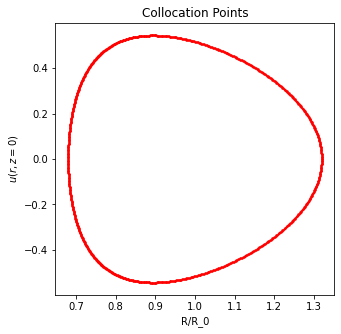

In [ ]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [ ]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)


## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.129131 s



/Users/alankaptanoglu/deepxde_copy/deepxde/maps/fnn.py:112: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 4.125028 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.05e+00, 9.73e-02]    [1.11e+00, 0.00e+00]    []  
1         [8.59e-01, 3.01e+00]    [9.21e-01, 0.00e+00]    []  
2         [9.52e-01, 2.84e-01]    [1.01e+00, 0.00e+00]    []  
3         [1.03e+00, 2.90e-01]    [1.09e+00, 0.00e+00]    []  
4         [1.04e+00, 8.11e-01]    [1.10e+00, 0.00e+00]    []  
5         [1.02e+00, 5.49e-01]    [1.08e+00, 0.00e+00]    []  
6         [9.80e-01, 1.52e-01]    [1.04e+00, 0.00e+00]    []  
7         [9.41e-01, 1.45e-03]    [1.00e+00, 0.00e+00]    []  
8         [9.03e-01, 9.55e-02]    [9.64e-01, 0.00e+00]    []  
9         [8.72e-01, 2.32e-01]    [9.33e-01, 0.00e+00]    []  
10        [8.51e-01, 2.31e-01]    [9.13e-01, 0.00e+00]    []  
11        [8.37e-01, 1.22e-01]    [8.99e-01, 0.00e+00]    []  
12        [8.23e-01, 2.75e-02]    [8.84e-01, 0.00e+00]    []  
13        [8.00e-01, 2.65e-02]    [8.62

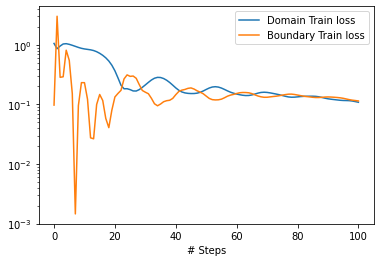

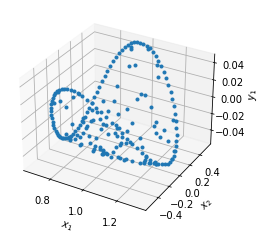

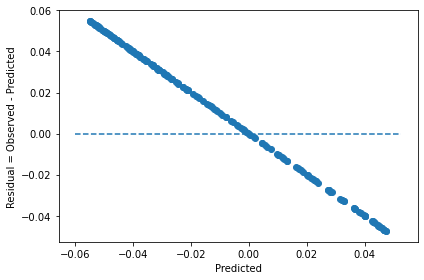

Accuracy
Mean residual: 0.36984023


In [4]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10272022"
CONFIG = "ITER_Hard"
LR = 2e-2
DEPTH = 3
BREADTH = 20
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([2] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")
net.apply_output_transform(modify_output)
model = dde.Model(data, net)

decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,100]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 1)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

## Plotting

#### Before BFGS

Average normalized percent error on midplane =  74.3865239911183
Max normalized percent error on midplane =  141.44455555908561
(501, 501)
Average normalized percent error =  54.45422479742166
Max normalized percent error =  140.6563471705607


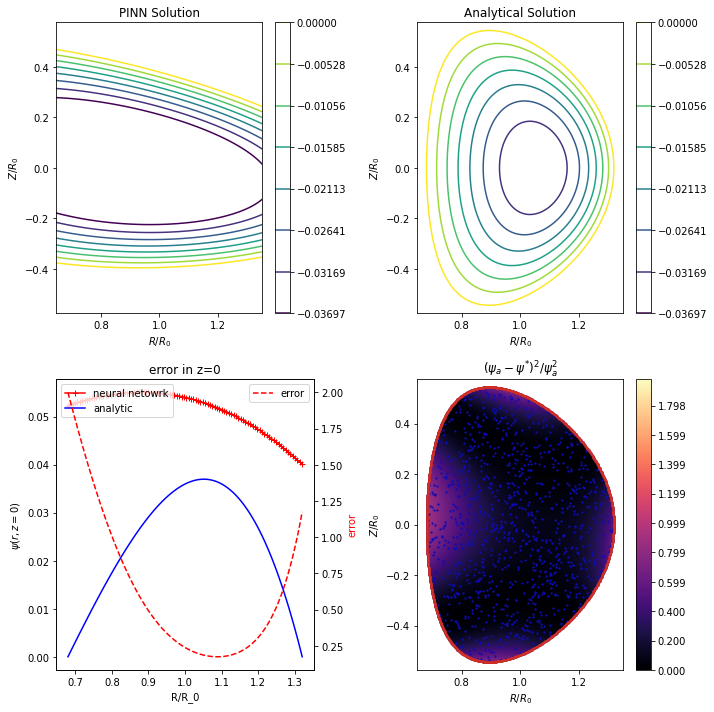

In [5]:
# Evaluation
from utils.utils import evaluate,evaluate_eq, relative_error_plot
ITER = GS_Linear(eps= 0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
x,y,psi_pred,psi_true,error=evaluate(ITER,model)
x_eq, psi_true_eq, psi_pred_eq, e_eq= evaluate_eq(ITER,model)
X_test = spatial_domain.random_points(333)

# Plotting Setup
print(psi_pred.shape)
fig,axs=plt.subplots(2,2,figsize=(10,10))
ax1,ax2,ax3,ax4=axs[0][0],axs[0][1],axs[1][0],axs[1][1]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred,levels=levels)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true,levels=levels)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

# Plot 3 - Equatorial Error
twin3 = ax3.twinx()
ax3.plot(x_eq, -psi_pred_eq,marker="+",color="red",label="neural netowrk")
ax3.plot(x_eq, -psi_true_eq,color="blue",label="analytic")
twin3.plot(x_eq, e_eq, color='red',linestyle='--',label="error")
twin3.yaxis.get_major_formatter().set_scientific(True)
ax3.set_title('error in z=0')
ax3.set_xlabel('R/R_0')
ax3.set_ylabel(r'$\psi(r,z=0)$')
ax3.legend(loc='upper left')
twin3.legend(loc='upper right')
twin3.set_ylabel('error', color='red')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Plot 4 - Relative Error
fig, ax4 = relative_error_plot(fig,ax4,x,y,error,model,ITER,X_test=X_test)
# ax4.set_title(r'$($\psi$_{n}-u^{*})^2/u_{a}^2$')
ax4.set_title(r'($\psi_{a}-\psi^{*})^2/\psi_{a}^2$')
ax4.set_xlabel(r'$R/R_{0}$')
ax4.set_ylabel(r'$Z/R_{0}$')
ax4.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

fig.tight_layout()
plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_before_BFGS.jpg')




#### After BFGS

Compiling model...
'compile' took 8.240263 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.09e-01, 1.14e-01]    [1.55e-01, 0.00e+00]    []  
110       [7.21e-02, 9.98e-02]                                
120       [4.25e-02, 8.35e-04]                                
130       [4.29e-03, 5.67e-03]                                
140       [1.91e-03, 1.22e-04]                                
150       [3.87e-04, 1.54e-04]                                
160       [2.99e-04, 7.38e-05]                                
170       [2.33e-04, 8.68e-05]                                
180       [2.26e-04, 1.89e-05]                                
190       [1.98e-04, 7.45e-06]                                
200       [1.74e-04, 1.08e-05]                                
210       [1.41e-04, 1.44e-05]                                
220       [1.28e-04, 1.55e-05]                                
230       [1.19e-04, 1.92e-05]                

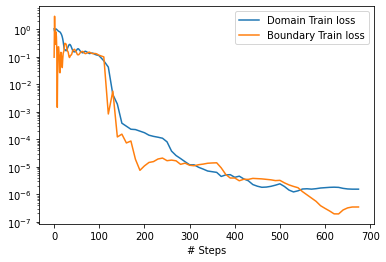

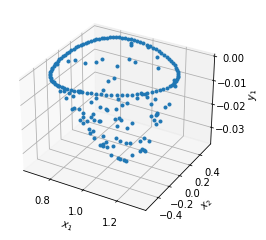

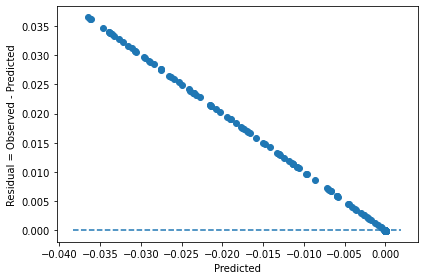

In [6]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


Average normalized percent error on midplane =  0.04252662434354159
Max normalized percent error on midplane =  0.2963245812950392
(501, 501)
Average normalized percent error =  0.04216294167785856
Max normalized percent error =  0.29129640625991626


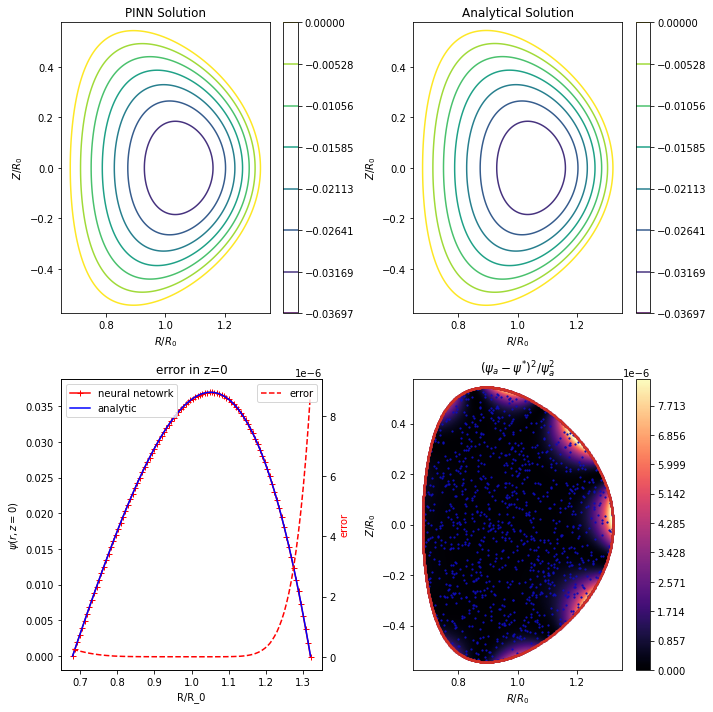

In [7]:
# Evaluation
from utils.utils import evaluate,evaluate_eq, relative_error_plot
x,y,psi_pred,psi_true,error=evaluate(ITER,model)
x_eq, psi_true_eq, psi_pred_eq, e_eq= evaluate_eq(ITER,model)
X_test = spatial_domain.random_points(333)

# Plotting Setup
print(psi_pred.shape)
fig,axs=plt.subplots(2,2,figsize=(10,10))
ax1,ax2,ax3,ax4=axs[0][0],axs[0][1],axs[1][0],axs[1][1]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred,levels=levels)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true,levels=levels)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

# Plot 3 - Equatorial Error
twin3 = ax3.twinx()
ax3.plot(x_eq, -psi_pred_eq,marker="+",color="red",label="neural netowrk")
ax3.plot(x_eq, -psi_true_eq,color="blue",label="analytic")
twin3.plot(x_eq, e_eq, color='red',linestyle='--',label="error")
twin3.yaxis.get_major_formatter().set_scientific(True)
ax3.set_title('error in z=0')
ax3.set_xlabel('R/R_0')
ax3.set_ylabel(r'$\psi(r,z=0)$')
ax3.legend(loc='upper left')
twin3.legend(loc='upper right')
twin3.set_ylabel('error', color='red')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Plot 4 - Relative Error
fig, ax4 = relative_error_plot(fig,ax4,x,y,error,model,ITER,X_test=X_test)
# ax4.set_title(r'$($\psi$_{n}-u^{*})^2/u_{a}^2$')
ax4.set_title(r'($\psi_{a}-\psi^{*})^2/\psi_{a}^2$')
ax4.set_xlabel(r'$R/R_{0}$')
ax4.set_ylabel(r'$Z/R_{0}$')
ax4.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

fig.tight_layout()
plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS.jpg')





True volume =  0.5391868755298633
predicted volume =  0.5391981138294926
True Cp =  2.7699789611805876
predicted Cp =  2.7702100528482534
True qstar =  1.545229123372811
True beta_p =  1.2295054750228174
True beta_t =  0.052728407379332855
True beta =  0.05056009395155768
Predicted qstar =  1.5453580375559333
Predicted beta_p =  1.22962650282181
Predicted beta_t =  0.05272480002648908
Predicted beta =  0.050556981791611735


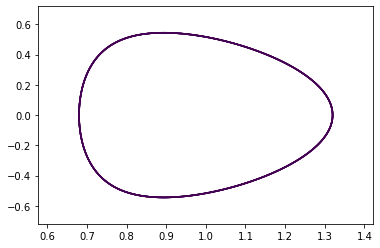

In [8]:
# Store Values
engineering_params = {
    "true_volume": 0.0,
    "pred_volume": 0.0,
    "true_Cp": 0.0,
    "pred_Cp": 0.0,
    "true_qstar": 0.0,
    "pred_qstar": 0.0,
    "true_beta_p": 0.0,
    "pred_beta_p": 0.0,
    "true_beta_t": 0.0,
    "pred_beta_t": 0.0,
    "true_beta": 0.0,
    "pred_beta": 0.0,
}

# Compute a contour integral
def area(vs):
    a = 0
    x0, y0 = vs[0]
    for [x1, y1] in vs[1:]:
        dx = x1 - x0
        dy = y1 - y0
        a += 0.5 * (y0 * dx - x0 * dy)
        x0 = x1
        y0 = y1
    return a

# Compute Volume from psi = 0 flux surface for true and predicted
c = plt.contour(x, y, psi_true, [0])
v = c.collections[0].get_paths()[0].vertices
print('True volume = ', area(v))
engineering_params["true_volume"] = area(v)

c = plt.contour(x, y, psi_pred, [0])
v = c.collections[0].get_paths()[0].vertices
print('predicted volume = ', area(v))
engineering_params["pred_volume"] = area(v)

def Cp(vs):
    a = 0
    x0, y0 = vs[0]
    for [x1, y1] in vs[1:]:
        dx = x1 - x0
        dy = y1 - y0
        dy_dx = dy / dx
        a += np.sqrt(1 + dy_dx ** 2) * abs(dx)
        x0 = x1
        y0 = y1
    return a

# Compute Cp from psi = 0 flux surface for true and predicted
c = plt.contour(x, y, psi_true, [0])
v = c.collections[0].get_paths()[0].vertices
print('True Cp = ', Cp(v))
engineering_params["true_Cp"] = Cp(v)

c = plt.contour(x, y, psi_pred, [0])
v = c.collections[0].get_paths()[0].vertices
print('predicted Cp = ', Cp(v))
engineering_params["pred_Cp"] = Cp(v)

# Using Green's theorem again
def qstar_integral(vs):
    a = 0
    x0, y0 = vs[0]
    for [x1, y1] in vs[1:]:
        dx = x1 - x0
        dy = y1 - y0
        M = - 1 / x1
        a += M * dy
        x0 = x1
        y0 = y1
    return a

# Compute qstar from psi = 0 flux surface for true and predicted
c = plt.contour(x, y, psi_true, [0])
v = c.collections[0].get_paths()[0].vertices
mu0 = 4 * np.pi * 10 ** (-7)
I = 15 * 10 ** 6
a = 2.0
R0 = 6.2
epsilon = 0.32
B0 = 5.3
psi0 = - mu0 * I * a / epsilon / (-0.155 * qstar_integral(v) + 1.115 * area(v))
qstar = - (a * R0 * B0 * Cp(v)) / (psi0 * (-0.155 * qstar_integral(v) + 1.115 * area(v)))
print('True qstar = ', qstar)
engineering_params["true_qstar"] = qstar

psi_average = np.trapz(np.trapz(psi_true * x[0, :], x[0, :], axis=0), y[:, 0])
beta_p = 2 * 1.155 * Cp(v) ** 2 * psi_average / (
    area(v) * (-0.155 * qstar_integral(v) + 1.115 * area(v)) ** 2
)
print('True beta_p = ', beta_p)
print('True beta_t = ', epsilon ** 2 * beta_p / qstar ** 2)
print('True beta = ', epsilon ** 2 * beta_p / (qstar ** 2 + epsilon ** 2))
engineering_params["true_beta_p"] = beta_p
engineering_params["true_beta_t"] = epsilon ** 2 * beta_p / qstar ** 2
engineering_params["true_beta"] = epsilon ** 2 * beta_p / (qstar ** 2 + epsilon ** 2)


c = plt.contour(x, y, psi_pred, [0])
v = c.collections[0].get_paths()[0].vertices
psi_average = np.trapz(np.trapz(psi_pred * x[0, :], x[0, :], axis=0), y[:, 0])
psi0 = - mu0 * I * a / epsilon / (-0.155 * qstar_integral(v) + 1.115 * area(v))
qstar = - (a * R0 * B0 * Cp(v)) / (psi0 * (-0.155 * qstar_integral(v) + 1.115 * area(v)))
print('Predicted qstar = ', qstar)
engineering_params["pred_qstar"] = qstar

beta_p = 2 * 1.155 * Cp(v) ** 2 * 0.018170271593863394 / (
    area(v) * (-0.155 * qstar_integral(v) + 1.115 * area(v)) ** 2
)
print('Predicted beta_p = ', beta_p)
print('Predicted beta_t = ', epsilon ** 2 * beta_p / qstar ** 2)
print('Predicted beta = ', epsilon ** 2 * beta_p / (qstar ** 2 + epsilon ** 2))
engineering_params["pred_beta_p"] = beta_p
engineering_params["pred_beta_t"] = epsilon ** 2 * beta_p / qstar ** 2
engineering_params["pred_beta"] = epsilon ** 2 * beta_p / (qstar ** 2 + epsilon ** 2)

